In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [79]:
class FingerPrint:
    def __init__(self,
                 A,
                 B,
                 poscar,
                 Rmax=10,
                 delta=0.08,
                 sigma=0.03,
                 dirac='s'):
        """
        poscar: path of POSCAR file. (in direct format)
        Rmax: threshold radius
               (valid value: 1-30)
        delta: discretization of fingerprint function 
               (valid value: 0.01-0.2)
        sigma: Gaussian broadening of interatomic distances
               (valid value: 0.01-0.1)
        dirac: 's' for square-form dirac function or 
               'g' for Gaussian broaden dirac function.
        """
        self.A = A
        self.B = B
        self.poscar = poscar
        
        self.Rmax = Rmax
        self.delta = delta
        self.sigma = sigma
        self.dirac = dirac
        
        self.R = np.arange(0, self.Rmax, self.delta)
        self.fingerprint = np.zeros_like(self.R)
        
        self.tolerance = 1e-3
        
        # read poscar
        self.lattice = None
        self.atom_species = None
        self.atom_num = None
        self.position = [] # list of dictionary
        self.read_poscar()
        
        # search A and B
        self.idx_A = None
        self.idx_B = None
        self.search_A_B()
        
        # volume of unit cell
        self.V_unit = np.dot(
            np.cross(self.lattice[0], self.lattice[1]), 
            self.lattice[2])
        
        # extended coordinaitons of B
        self.B_ext = None
        self.get_extended_coords_B()
        
        self.get_fingerprint()
    
    def read_poscar(self):
        with open(self.poscar, 'r') as f:
            lines = [line.strip() for line in f]
        
        scale = float(lines[1])
        self.lattice = [line.split() for line in lines[2:5]]
        self.lattice = np.array(self.lattice, dtype=float)
        
        self.atom_species = lines[5].split()
        self.atom_num = np.array(lines[6].split(), dtype=int)
        
        # check whether poscar is direct type
        check_direct = lines[7][0]
        if not(check_direct == 'D' or check_direct == 'd'):
            print('only direct type POSCAR is supported.')
            sys.exit(0)
        
        start = 8
        for atom, num in zip(self.atom_species, self.atom_num):
            dic_atom = {}
            dic_atom['name'] = atom
            dic_atom['num'] = num
            
            end = start + num
            coords = [line.split()[:3] for line in lines[start:end]]
            dic_atom['coords'] = np.array(coords, dtype=float)
            start = end
            
            self.position += [dic_atom]
            
    def gaussian_func(self, x):
        x = np.array(x)
        return (1/np.sqrt(2*np.pi*self.sigma**2)) *\
               np.exp(-x**2 / (2*self.sigma**2))
    
    def square_func(self, x):
        x = np.array(x)
        return np.array(np.abs(x) <= self.sigma)/(2*self.sigma)
    
    def dirac_func(self, x):
        if self.dirac[0] == 'g':
            return self.gaussian_func(x)
        elif self.dirac[0] == 's':
            return self.square_func(x)
        else:
            print(f"{self.dirac} is not defined.")
            sys.exit(0)
            
    def search_A_B(self):
        for i, atom in enumerate(self.position):
            if atom['name'] == self.A:
                self.idx_A = i
            if atom['name'] == self.B:
                self.idx_B = i
    
    def get_extended_coords_B(self):
        length_lat = np.sqrt(np.sum(self.lattice ** 2, axis=1))
        m = shift = np.floor(self.Rmax / length_lat) + 1
        
        mx = np.arange(-m[0], m[0]+1)
        my = np.arange(-m[1], m[1]+1)
        mz = np.arange(-m[2], m[2]+1)
        
        nx, ny, nz = len(mx), len(my), len(mz)
        
        shifts = np.zeros((nx*ny*nz, 3), dtype=int)
        shifts[:,0] = np.repeat(mx, ny*nz)
        shifts[:,1] = np.tile(np.repeat(my, nz), nx)
        shifts[:,2] = np.tile(mz, nx*ny)
        
        for coords_B in self.position[self.idx_B]['coords']:
            if self.B_ext is None:
                self.B_ext = shifts + coords_B
            else:
                self.B_ext = np.append(self.B_ext, 
                                       shifts + coords_B, 
                                       axis=0)
             
    def get_fingerprint(self):
        for coord_A in self.position[self.idx_A]['coords']:
            self.fingerprint += self.get_fingerprint_i(coord_A)
        
        self.fingerprint *= self.V_unit / self.position[self.idx_A]['num']
        self.fingerprint -= 1
        
    def get_fingerprint_i(self, coord_A_i):
        # calculate R_ij
        disp = self.B_ext - coord_A_i
        disp_cart = np.dot(disp[:,:], self.lattice)
        R_ij = np.sqrt(np.sum(disp_cart**2, axis=1))
        
        # When A=B, i=j should be excluded. (else, diverge)
        if self.idx_A == self.idx_B:
            R_ij[R_ij < self.tolerance] = 1e5
            
        # number of B atoms within Rmax
        N_B = np.sum(R_ij <= self.Rmax)
        
        fingerprint_i = np.zeros_like(self.fingerprint)
        for idx, r in enumerate(self.R):
            fingerprint_i[idx] = np.sum(self.dirac_func(r - R_ij) / R_ij**2)\
                / (4 * np.pi * N_B * self.delta)

        return fingerprint_i
    
    def plot_fingerprint(self, disp=True):
        plt.plot(self.R, 
                 self.fingerprint,
                 label=f"{self.A}-{self.B}")
        plt.axhline(0, 0, 1, color='k', linestyle='--', linewidth=1)
        
        plt.xlabel("Distance (Å)", fontsize=13)
        plt.ylabel('Intensity', fontsize=13)
        
        plt.legend(fontsize=12)
        if disp:
            plt.show()

In [97]:
fp_tio = FingerPrint(A='Ti', 
                      B='O',
                      Rmax=17,
                      sigma=0.03,
                      delta=0.003,
                      poscar='POSCAR_TiO2',
                      dirac='g')

fp_titi = FingerPrint(A='Ti', 
                       B='Ti',
                       Rmax=17,
                       sigma=0.03,
                       delta=0.003,
                       poscar='POSCAR_TiO2',
                       dirac='g')

fp_oo = FingerPrint(A='O', 
                      B='O',
                      Rmax=17,
                      sigma=0.03,
                      delta=0.003,
                      poscar='POSCAR_TiO2',
                      dirac='g')

x_tio2 = np.append(np.append(fp_tio.R, fp_titi.R+17), fp_oo.R+34)
y_tio2 = np.append(np.append(fp_tio.fingerprint, fp_titi.fingerprint),fp_oo.fingerprint)

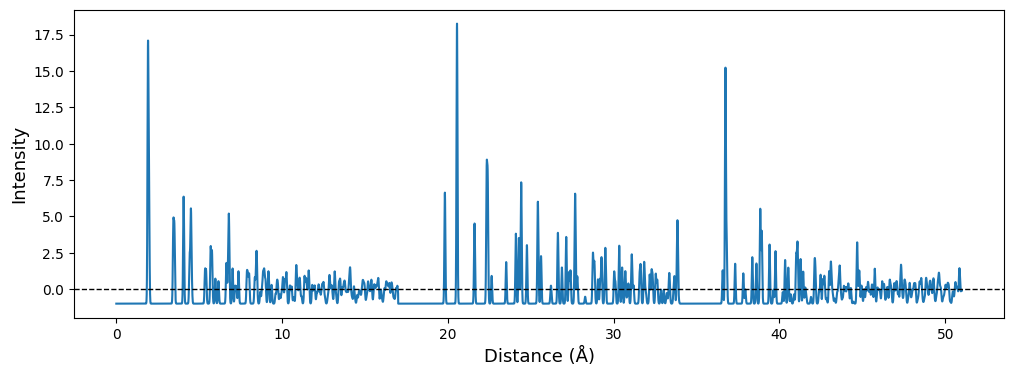

In [98]:
plt.figure(figsize=(12,4))
plt.plot(x_tio2,y_tio2)
plt.axhline(0, 0, 1, color='k', linestyle='--', linewidth=1)

plt.xlabel("Distance (Å)", fontsize=13)
plt.ylabel('Intensity', fontsize=13)

plt.show()

In [99]:
fp_tao = FingerPrint(A='Ta',B='O',Rmax=17,sigma=0.03,delta=0.009,poscar='POSCAR_Ta2O5',dirac='g')
fp_tata = FingerPrint(A='Ta',B='Ta',Rmax=17,sigma=0.03,delta=0.009,poscar='POSCAR_Ta2O5',dirac='g')
fp_oo_ = FingerPrint(A='O',B='O',Rmax=17,sigma=0.03,delta=0.009,poscar='POSCAR_Ta2O5',dirac='g')

x_ta2o5 = np.append(np.append(fp_tao.R, fp_tata.R+17), fp_oo_.R+34)
y_ta2o5 = np.append(np.append(fp_tao.fingerprint, fp_tata.fingerprint),fp_oo_.fingerprint)

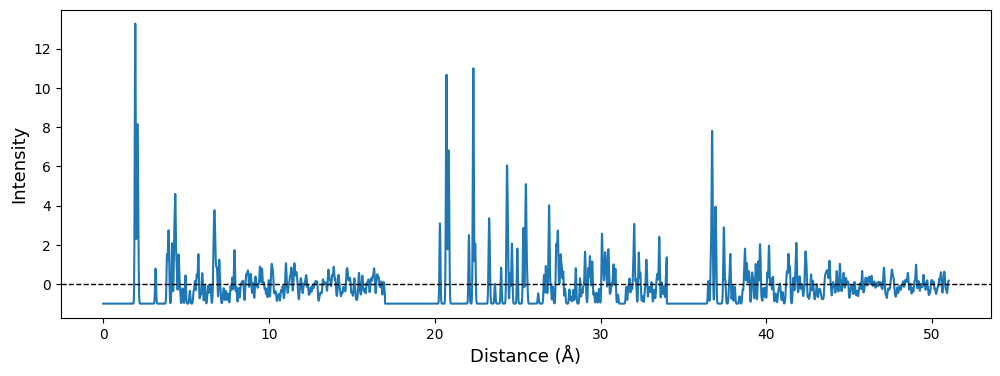

In [100]:
plt.figure(figsize=(12,4))
plt.plot(x_ta2o5,y_ta2o5)
plt.axhline(0, 0, 1, color='k', linestyle='--', linewidth=1)

plt.xlabel("Distance (Å)", fontsize=13)
plt.ylabel('Intensity', fontsize=13)

plt.show()